In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from mvp.env_pendulum import PendulumEnv

from itertools import count
import torch
import gym
from gym.envs.registration import register
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Exporting PPO Control Coordinate For Imitation

/Users/kevinb/anaconda3/lib/python3.10/site-packages/gym/envs/registration.py:498: UserWarning: WARN: Overriding environment Pendulum-v1 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


Collected data saved to /Users/kevinb/Desktop/CL/VNL-MVP/notebook/../mvp/data/pendulum_ppo_imitation_run_4.npz


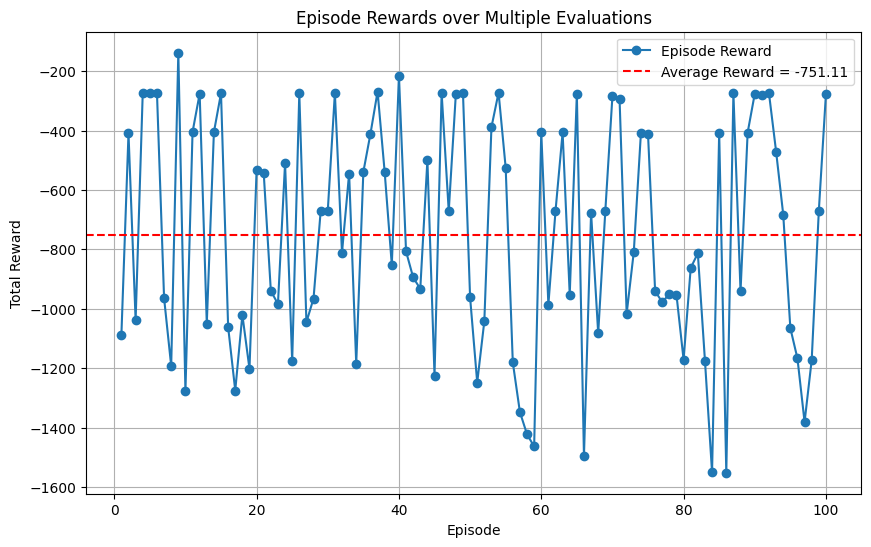

In [3]:
from mvp.ppo_continuous import ActorCritic
model_path = os.path.join(os.getcwd(), "..", "mvp", "params", "ppo_ITER_300_KL_0.01_RUN_1.pth")
env = PendulumEnv(render_mode=None)

# Extract environment details
n_actions = env.action_space.shape[0]
state, _ = env.reset()
n_observations = len(state)
num_eval_episodes = 100  # Number of episodes for data collection
max_timesteps = 200  # Maximum timesteps per episode (as per PendulumEnv's max_episode_steps)

# Initialize and load the trained ActorCriticUPN model
model = ActorCritic(n_observations, n_actions).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Lists to store collected data
collected_states = []
collected_actions = []
collected_next_states = []
episode_rewards = []

for i_episode in range(1, num_eval_episodes + 1):
    state, _ = env.reset()
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    episode_reward = 0

    for t in range(1, max_timesteps + 1):
        with torch.no_grad():
            # Get action mean from the model
            action_mean, _, _ = model(state_tensor)
        
        # Use deterministic action (mean) for evaluation
        action = action_mean.cpu().numpy()[0]
        
        # Execute the action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        
        # Store the state, action, and next_state
        collected_states.append(state)
        collected_actions.append(action)
        collected_next_states.append(next_state)
        
        # Transition to the next state
        state = next_state
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        # Check if the episode is done
        if terminated or truncated:
            print(f"Episode {i_episode} finished after {t} timesteps with reward {episode_reward:.2f}")
            break
    
    episode_rewards.append(episode_reward)

env.close()

# Convert collected data to NumPy arrays
collected_states = np.array(collected_states)
collected_actions = np.array(collected_actions)
collected_next_states = np.array(collected_next_states)
episode_rewards = np.array(episode_rewards)

# Define the directory to save the collected data
save_dir = os.path.join(os.getcwd(), '..', 'mvp', 'data')
os.makedirs(save_dir, exist_ok=True)

# Define the filename with run number (auto-increment based on existing files)
import re

existing_files = os.listdir(save_dir)
run_numbers = [int(re.search(r'run_(\d+)', f).group(1)) for f in existing_files if re.search(r'run_(\d+)', f)]
run_number = max(run_numbers) + 1 if run_numbers else 1

data_filename = f"pendulum_ppo_imitation_run_{run_number}.npz"
data_path = os.path.join(save_dir, data_filename)

# Save the collected data
np.savez_compressed(
    data_path,
    states=collected_states,
    actions=collected_actions,
    next_states=collected_next_states,
    rewards=episode_rewards
)

print(f"Collected data saved to {data_path}")

# Plotting the episode rewards for validation
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_eval_episodes + 1), episode_rewards, marker='o', label="Episode Reward")
plt.axhline(y=episode_rewards.mean(), color='r', linestyle='--', label=f'Average Reward = {episode_rewards.mean():.2f}')
plt.title("Episode Rewards over Multiple Evaluations")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()

In [6]:
save_dir = os.path.join(os.getcwd(), "..", 'mvp', 'params')
os.makedirs(save_dir, exist_ok=True)

import re
existing_files = os.listdir(save_dir)
run_numbers = [int(re.search(r'run_(\d+)', f).group(1)) for f in existing_files if re.search(r'run_(\d+)', f)]
run_number = max(run_numbers) + 1 if run_numbers else 1

data_filename = f"pendulum_fmppo_{1000}_KL_{0.01}_{run_number}.pth"
data_path = os.path.join(save_dir, data_filename)
data_path

'/Users/kevinb/Desktop/CL/VNL-MVP/notebook/../mvp/params/pendulum_fmppo_1000_KL_0.01_1.pth'

In [ ]:
path = os.path.join(os.getcwd(), "..", "mvp", "params", "pendulum_dqn_discrete_retrain.pth")